# Jupyter notebook to test and understand the analyse_regen function

Imports necessary below

In [18]:
import pandas as pd
import numpy as np
import math as m
import matplotlib.pyplot as plt
from scipy.signal import savgol_filter
from scipy.ndimage.filters import uniform_filter1d

Argument declaration in function 
Need to change this depending on which files you are using (time in seconds)

In [19]:
#The function below is very similar to the one above but for regeneration step analysis
MS_csv, flow_csv='220803-UiO66blank-dry-22%CO2-40C.csv', '220803-UiO66blank-dry-22%CO2-40C20220803102447.txt'
T_regen=398
Discount_He=True 
Low_conc_CO2=False 
P_sat_H2O_bath, ms_start, flow_start, regen_start = 0, 16, 0, 5730 
regen_end=7794
filter_window=15 
filelabel='test'
smoothing_start={'CO2':0, 'H2O':0, 'N2':0, 'He':0} 
water_outliers=False
water_outlier_value=2.5E-5
full_output=False
backgrounds='Default'
relative_sensitivities='Default'


This section is used to define standard values used in code

In [20]:
MS_header_row = 26
P_atm = 1.01325E5 #Pa
P_exp = P_atm #Pa
R = 8.314 #J/mol/K
if backgrounds == 'Default':
    background = {'N2':3.78E-9, 'He':1.44E-8, 'CO2':4.16E-11, 'O2':1.86E-10, 'H2O':3.50E-11} #Background MS values to subtract from MS data [torr]
else:
    background = backgrounds
Mw =  {'N2':28E-3, 'He':4E-3, 'CO2':44E-3, 'O2':32E-3, 'H2O':18E-3} #kg/mol
max_outlet = 93.59 * 1.66667e-8 #mg/min to kg/s
max_N2 = 1.66667e-8*100*P_atm/(R*273.15) #mol/s
max_He = 1.66667e-8*141*P_atm/(R*273.15) #mol/s
coriolis_cal = {'N2':1.06, 'He':1.09, 'CO2':1.09, 'O2':1, 'H2O':1.02} 
if relative_sensitivities == 'Default':
    if Low_conc_CO2 == True:
        max_CO2 = 1.66667e-8*0.5*P_atm/(R*273.15) #Max flow rate in the CO2 mass flow meter when its set to fluid 2 mol/s 
        RS = {'N2':1, 'He':1.92, 'CO2':0.021, 'O2':0.98, 'H2O':0.0157} #Defining mass spec relative sensitivities [-]
    
    else:
        max_CO2 = 1.66667e-8*2*P_atm/(R*273.15) #Max flow rate in the CO2 mass flow meter when its set to fluid 1 mol/s 
        RS = {'N2':1, 'He':1.92, 'CO2':0.86, 'O2':0.98, 'H2O':0.0157} #Defining mass spec relative sensitivities [-]
else: #This is if we have selected manual values of relative sensitivities
    if Low_conc_CO2 == True:
        max_CO2 = 1.66667e-8*0.5*P_atm/(R*273.15) #mol/s
        RS = relative_sensitivities #Defining mass spec relative sensitivities [-]
    
    else:
        max_CO2 = 1.66667e-8*2*P_atm/(R*273.15) #mol/s
        RS = relative_sensitivities #Defining mass spec relative sensitivities [-]

H2O_ratio = P_sat_H2O_bath/P_atm


The below cell is used to extract the data from the csv and txt files into pandas dataframes. Then adds the respective start times onto each dataframes.
Finally they are merged together.

In [21]:
df_MS = pd.read_csv(MS_csv, header=(MS_header_row-1)).drop(['Time', 'Unnamed: 7'], axis=1)
df_MS.loc[:,'Time [s]'] = pd.Series([i/1000 + ms_start for i in df_MS['ms']] , index=df_MS.index)

df_FM = pd.read_csv(flow_csv, sep=';', names = ['Time', 'CO2', 'Time 2', 'He', 'Time 3', 'N2', 'Time 4', 'Outlet']).drop(['Time 2', 'Time 3', 'Time 4'], axis=1)
df_FM.loc[:,'Time [s]'] = pd.Series([i + flow_start for i in df_FM['Time']] , index=df_FM.index)

df_all = pd.merge(df_MS, df_FM, on='Time [s]',how='outer', sort=True).drop(['Time', 'ms'], axis=1).rename(columns={"Nitrogen": "N2 pressure [torr]", "Water": "H2O pressure [torr]", "Carbon dioxide": "CO2 pressure [torr]", "Oxygen": "O2 pressure [torr]", "Helium": "He pressure [torr]", "CO2": "CO2 flow [%]", "He": "He flow [%]", "N2": "N2 flow [%]", "Outlet": "Outlet flow [%]"}) 


In [22]:
type(df_all['Time [s]'])
type(df_all.loc[:, 'Time [s]'])
# assert type(df_all) == type(df_FM)
# both of these are series 
# assertion error is raised due to series not having a truth value?
#assert df_all['Time [s]'] == df_all.loc[:, 'Time [s]']
#df_all['Time [s]'][10:22]'
print(float("NaN"))
type(float('NaN'))
#for i in range(1, 8):
#    print(i)
df_all

nan


,H2O pressure [torr],CO2 pressure [torr],O2 pressure [torr],He pressure [torr],N2 pressure [torr],Time [s],CO2 flow [%],He flow [%],N2 flow [%],Outlet flow [%]
0,NaN,NaN,NaN,NaN,NaN,0.001000,0.0,0.00000,0.0,0.003125
1,NaN,NaN,NaN,NaN,NaN,0.101006,0.0,0.00000,0.0,0.003125
2,NaN,NaN,NaN,NaN,NaN,0.201011,0.0,0.00000,0.0,0.003125
3,NaN,NaN,NaN,NaN,NaN,0.301017,0.0,0.00000,0.0,0.003125
4,NaN,NaN,NaN,NaN,NaN,0.401023,0.0,0.00000,0.0,0.003125
...,...,...,...,...,...,...,...,...,...,...
103311,NaN,NaN,NaN,NaN,NaN,10576.570000,0.0,14.18125,0.0,4.350000
103312,NaN,NaN,NaN,NaN,NaN,10576.670000,0.0,14.18125,0.0,4.346875
103313,NaN,NaN,NaN,NaN,NaN,10576.770000,0.0,14.18437,0.0,4.346875
103314,NaN,NaN,NaN,NaN,NaN,10576.870000,0.0,14.18437,0.0,4.346875


next the data is interpolated so that the random readings from MS match those of the FS. This interpolation is achieved through a time average 


In [23]:
#In this for loop we are interpolating between each time point that exists for the MS data, to get the flows from the coriolis at that time
for comp in ['CO2', 'N2', 'He', 'Outlet']:
    label = comp + ' flow [%]'
    interpolated_flow = []
    interpolated_flow.append(float("NaN"))
    for i in range(1,len(df_all['Time [s]'])-1):
        if m.isnan(df_all[label][i]) == True:
            time_range = df_all['Time [s]'][i+1] - df_all['Time [s]'][i-1]
            time_int = df_all['Time [s]'][i] - df_all['Time [s]'][i-1]
            time_frac = time_int/time_range
            flow_before = df_all[label][i-1]
            flow_range = df_all[label][i+1] - df_all[label][i-1]
            flow_value = flow_before + flow_range*time_frac
            interpolated_flow.append(flow_value)
        else:
            interpolated_flow.append(df_all[label][i])
    interpolated_flow.append(float("NaN"))
    df_all.loc[:,'Interpolated ' + label] = pd.Series(interpolated_flow, index=df_all.index)


In [24]:

df_all

,H2O pressure [torr],CO2 pressure [torr],O2 pressure [torr],He pressure [torr],N2 pressure [torr],Time [s],CO2 flow [%],He flow [%],N2 flow [%],Outlet flow [%],Interpolated CO2 flow [%],Interpolated N2 flow [%],Interpolated He flow [%],Interpolated Outlet flow [%]
0,NaN,NaN,NaN,NaN,NaN,0.001000,0.0,0.00000,0.0,0.003125,NaN,NaN,NaN,NaN
1,NaN,NaN,NaN,NaN,NaN,0.101006,0.0,0.00000,0.0,0.003125,0.0,0.0,0.00000,0.003125
2,NaN,NaN,NaN,NaN,NaN,0.201011,0.0,0.00000,0.0,0.003125,0.0,0.0,0.00000,0.003125
3,NaN,NaN,NaN,NaN,NaN,0.301017,0.0,0.00000,0.0,0.003125,0.0,0.0,0.00000,0.003125
4,NaN,NaN,NaN,NaN,NaN,0.401023,0.0,0.00000,0.0,0.003125,0.0,0.0,0.00000,0.003125
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
103311,NaN,NaN,NaN,NaN,NaN,10576.570000,0.0,14.18125,0.0,4.350000,0.0,0.0,14.18125,4.350000
103312,NaN,NaN,NaN,NaN,NaN,10576.670000,0.0,14.18125,0.0,4.346875,0.0,0.0,14.18125,4.346875
103313,NaN,NaN,NaN,NaN,NaN,10576.770000,0.0,14.18437,0.0,4.346875,0.0,0.0,14.18437,4.346875
103314,NaN,NaN,NaN,NaN,NaN,10576.870000,0.0,14.18437,0.0,4.346875,0.0,0.0,14.18437,4.346875


## Converting all the NaN to 0 

this is an edit to the original file so feel free not to run - current code does not like this change

In [25]:
#for comp in ['CO2', 'N2', 'He', 'Outlet']:
#    label = comp + ' flow [%]'
#    print(df_all['Interpolated ' + label])
print(df_all['Interpolated N2 flow [%]'][8000])

#df_all.astype(bool).sum(axis=0)

#df_all = df_all.fillna(0).astype(bool).sum(axis=0)
#df_all.astype(bool).sum(axis=0)


0.0


Time in the df_all is then subtracted by the start of regen so that the time at which regen starts is 0 **and this series then becomes the breakthrough time column** 

Dataframe is then shortened so all rows without MS readings are removed (therefore matching Coriolis to MS time readings) I believe this is achieved by . Need to go back up to look at how the pressures are calculated.

In [26]:
# just for testing 
#print(pd.isna(df_all['CO2 pressure [torr]'][0]))
#df_all['CO2 pressure [torr]']

In [27]:
#actual code
#Now converting the data time to the time of the breakthrough step
df_all.loc[:,'Breakthrough time [s]'] = pd.Series([i - regen_start for i in df_all['Time [s]']], index=df_all.index)
#Now deleting rows without MS values
df_all.loc[(abs(df_all['CO2 pressure [torr]']) == 0)]

df_breakthrough_start = df_all.loc[(abs(df_all['CO2 pressure [torr]']) > 0)]
#df_all
#df_breakthrough_start = df_breakthrough_start.fillna(0)
df_breakthrough_start

,H2O pressure [torr],CO2 pressure [torr],O2 pressure [torr],He pressure [torr],N2 pressure [torr],Time [s],CO2 flow [%],He flow [%],N2 flow [%],Outlet flow [%],Interpolated CO2 flow [%],Interpolated N2 flow [%],Interpolated He flow [%],Interpolated Outlet flow [%],Breakthrough time [s]
176,0.000000e+00,-7.892790e-10,1.927310e-08,0.000000e+00,9.834400e-08,17.522,NaN,NaN,NaN,NaN,0.00000,0.000000,0.000000,-0.020812,-5712.478
182,-6.138880e-10,-1.894280e-09,2.441270e-08,1.578560e-08,1.014380e-07,18.040,NaN,NaN,NaN,NaN,0.00000,0.000000,0.000000,-0.021812,-5711.960
189,1.632930e-09,5.524930e-11,2.917970e-08,2.367850e-10,1.138140e-07,18.557,NaN,NaN,NaN,NaN,0.00000,0.000000,0.000000,-0.025000,-5711.443
255,1.706910e-09,1.008310e-10,3.095920e-08,2.644100e-10,1.201130e-07,25.172,NaN,NaN,NaN,NaN,0.00000,0.000000,0.000000,-0.012920,-5704.828
397,1.859770e-09,1.011860e-11,3.221200e-08,4.672560e-11,1.291740e-07,39.320,NaN,NaN,NaN,NaN,0.00000,0.000000,0.000000,0.021875,-5690.680
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
102088,1.271970e-11,1.615660e-08,-1.251470e-11,1.398210e-07,1.505560e-08,10450.842,NaN,NaN,NaN,NaN,5.99608,3.994545,14.181250,9.756136,4720.842
102234,1.571540e-11,1.637370e-08,3.237900e-12,1.386770e-07,1.505560e-08,10465.758,NaN,NaN,NaN,NaN,0.00000,0.000000,14.181250,8.271875,4735.758
102359,1.652580e-11,1.626320e-08,7.709290e-13,1.393090e-07,1.308310e-08,10478.574,NaN,NaN,NaN,NaN,0.00000,0.000000,14.181250,5.600000,4748.574
102504,2.325400e-11,7.904640e-09,-6.218830e-12,1.317310e-07,3.386820e-09,10493.491,NaN,NaN,NaN,NaN,0.00000,0.000000,14.184370,4.859375,4763.491


In [28]:
# testing out how the dataframe looks
#df_breakthrough_start
#df_all.loc[pd.notna(df_all['CO2 pressure [torr]'])]


Isolating the desorption curve as its own data frame


In [29]:

#Now we are only taking the part of the dataframe that we are interested in (ignoring drying, cooling, purging etc.)
df_not_breakthrough = df_breakthrough_start.loc[((df_breakthrough_start['Time [s]'] < regen_start))]
df_breakthrough = df_breakthrough_start.loc[((df_breakthrough_start['Time [s]'] > regen_start) & (df_breakthrough_start['Time [s]'] < regen_end))]
df_breakthrough.reset_index(drop=True, inplace=True)


In [30]:

#testing how the dataframe now looks 
df_not_breakthrough

,H2O pressure [torr],CO2 pressure [torr],O2 pressure [torr],He pressure [torr],N2 pressure [torr],Time [s],CO2 flow [%],He flow [%],N2 flow [%],Outlet flow [%],Interpolated CO2 flow [%],Interpolated N2 flow [%],Interpolated He flow [%],Interpolated Outlet flow [%],Breakthrough time [s]
176,0.000000e+00,-7.892790e-10,1.927310e-08,0.000000e+00,9.834400e-08,17.522,NaN,NaN,NaN,NaN,0.0,0.0,0.000000,-0.020812,-5712.478
182,-6.138880e-10,-1.894280e-09,2.441270e-08,1.578560e-08,1.014380e-07,18.040,NaN,NaN,NaN,NaN,0.0,0.0,0.000000,-0.021812,-5711.960
189,1.632930e-09,5.524930e-11,2.917970e-08,2.367850e-10,1.138140e-07,18.557,NaN,NaN,NaN,NaN,0.0,0.0,0.000000,-0.025000,-5711.443
255,1.706910e-09,1.008310e-10,3.095920e-08,2.644100e-10,1.201130e-07,25.172,NaN,NaN,NaN,NaN,0.0,0.0,0.000000,-0.012920,-5704.828
397,1.859770e-09,1.011860e-11,3.221200e-08,4.672560e-11,1.291740e-07,39.320,NaN,NaN,NaN,NaN,0.0,0.0,0.000000,0.021875,-5690.680
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
55204,5.254880e-12,-2.604640e-12,-1.541850e-13,1.118410e-07,1.173500e-11,5632.963,NaN,NaN,NaN,NaN,0.0,0.0,30.000000,8.542625,-97.037
55458,7.784100e-12,-2.683560e-13,4.394290e-12,1.121570e-07,-3.005590e-12,5659.040,NaN,NaN,NaN,NaN,0.0,0.0,29.996880,8.515625,-70.960
55691,1.915320e-12,2.209990e-12,8.403130e-12,1.112490e-07,7.602300e-12,5683.016,NaN,NaN,NaN,NaN,0.0,0.0,29.995102,8.546875,-46.984
55904,-8.594430e-13,4.104280e-13,-2.312780e-13,1.113290e-07,0.000000e+00,5704.891,NaN,NaN,NaN,NaN,0.0,0.0,29.996880,6.121875,-25.109


As there are 2 dataframes having been created: df_breakthrough and df_not_breakthrough then to get the initial values in the df_breakthrough df then the last values from df_not_breakthrough are selected to be the 1st values of df_breakthrough.

**possible error - why not take the average of first five vales to reduce possibility of random reading error?**

In [31]:
#Fetching the last values before breakthrough is started
n2_p = df_not_breakthrough['N2 pressure [torr]'].iloc[-1]
h2o_p = df_not_breakthrough['H2O pressure [torr]'].iloc[-1]
co2_p = df_not_breakthrough['CO2 pressure [torr]'].iloc[-1]
o2_p = df_not_breakthrough['O2 pressure [torr]'].iloc[-1]
he_p = df_not_breakthrough['He pressure [torr]'].iloc[-1]
time0 = df_not_breakthrough['Time [s]'].iloc[-1]
co2_f = df_not_breakthrough['Interpolated CO2 flow [%]'].iloc[-1]
n2_f = df_not_breakthrough['Interpolated N2 flow [%]'].iloc[-1]
he_f = df_not_breakthrough['Interpolated He flow [%]'].iloc[-1]
out_f = df_not_breakthrough['Interpolated Outlet flow [%]'].iloc[-1]


In [32]:
b_time = 0
#Inserting these values as 0 breakthrough time
df_breakthrough.loc[-1] = [n2_p, h2o_p, co2_p, o2_p, he_p, time0, float("NaN"), float("NaN"), float("NaN"), float("NaN"), co2_f, n2_f, he_f, out_f, b_time]
df_breakthrough.sort_values('Breakthrough time [s]', inplace=True)
df_breakthrough.reset_index(drop=True, inplace=True)
df_breakthrough

C:\Users\tmp10\AppData\Local\Temp\ipykernel_12616\3788514738.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_breakthrough.loc[-1] = [n2_p, h2o_p, co2_p, o2_p, he_p, time0, float("NaN"), float("NaN"), float("NaN"), float("NaN"), co2_f, n2_f, he_f, out_f, b_time]
C:\Users\tmp10\AppData\Local\Temp\ipykernel_12616\3788514738.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_breakthrough.sort_values('Breakthrough time [s]', inplace=True)


,H2O pressure [torr],CO2 pressure [torr],O2 pressure [torr],He pressure [torr],N2 pressure [torr],Time [s],CO2 flow [%],He flow [%],N2 flow [%],Outlet flow [%],Interpolated CO2 flow [%],Interpolated N2 flow [%],Interpolated He flow [%],Interpolated Outlet flow [%],Breakthrough time [s]
0,6.828890e-12,-1.841660e-12,-4.909350e-12,2.389870e-12,1.124340e-07,5726.767,NaN,NaN,NaN,NaN,0.0,0.0,29.997371,6.291609,0.000
1,4.911100e-14,5.777500e-12,2.466970e-12,1.119990e-07,8.506200e-11,5750.744,NaN,NaN,NaN,NaN,0.0,0.0,29.996880,12.550000,20.744
2,3.953430e-12,2.883410e-10,1.500730e-11,1.050140e-07,1.158560e-09,5774.479,NaN,NaN,NaN,NaN,0.0,0.0,29.995837,21.989587,44.479
3,1.193390e-11,2.597380e-10,6.321620e-12,1.173270e-07,3.382950e-09,5800.555,NaN,NaN,NaN,NaN,0.0,0.0,29.993178,11.193496,70.555
4,4.395430e-12,8.399570e-11,-3.160800e-12,1.173270e-07,1.738440e-09,5823.571,NaN,NaN,NaN,NaN,0.0,0.0,30.003120,10.162500,93.571
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
83,1.298980e-11,1.468060e-12,5.088130e-12,1.161430e-07,1.986780e-11,7686.905,NaN,NaN,NaN,NaN,0.0,0.0,29.996880,8.451389,1956.905
84,5.230320e-12,1.104990e-13,7.683590e-12,1.166160e-07,1.224330e-11,7710.880,NaN,NaN,NaN,NaN,0.0,0.0,30.000000,8.471875,1980.880
85,4.714660e-12,2.478350e-12,-1.053600e-12,1.168140e-07,2.030980e-11,7734.859,NaN,NaN,NaN,NaN,0.0,0.0,30.000998,8.467750,2004.859
86,3.904320e-12,5.524990e-13,7.182490e-12,1.166960e-07,2.030980e-11,7760.935,NaN,NaN,NaN,NaN,0.0,0.0,30.006000,8.493625,2030.935


In [33]:
df_breakthrough.drop(['CO2 flow [%]', 'He flow [%]', 'N2 flow [%]', 'Outlet flow [%]'], axis=1, inplace=True)
for comp in ['CO2', 'N2', 'He', 'H2O', 'O2']:
    label = comp + ' pressure [torr]'
    new_label = 'Corrected ' + label
    mole_frac_label = comp + 'mole fraction [-]'
    if comp == 'N2':
        corrected_list = []
        for i in range(len(df_breakthrough['Breakthrough time [s]'])): 
            if ((df_breakthrough[label][i] - background[comp] - 0.114*df_breakthrough['Corrected CO2 pressure [torr]'][i])/RS[comp]) > 0:
                corrected_list.append((df_breakthrough[label][i] - background[comp] - 0.114*df_breakthrough['Corrected CO2 pressure [torr]'][i])/RS[comp])
            else:
                corrected_list.append(0)   
        df_breakthrough.loc[:,new_label] = pd.Series(corrected_list, index=df_breakthrough.index)
    else:
        df_breakthrough.loc[:,new_label] = pd.Series([(i - background[comp])/RS[comp] if (i - background[comp])/RS[comp] > 0 else 0 for i in df_breakthrough[label]], index=df_breakthrough.index)
#for comp in ['CO2', 'N2', 'He', 'H2O', 'O2']:
#    label = 'Corrected ' +comp + ' pressure [torr]'
#    new_label = comp + ' mole fraction [-]'
#    molar_list = []
#    for i in range(len(df_breakthrough['Breakthrough time [s]'])): 
#        if Discount_He == True:
#            total = df_breakthrough['Corrected CO2 pressure [torr]'][i] + df_breakthrough['Corrected N2 pressure [torr]'][i] + df_breakthrough['Corrected H2O pressure [torr]'][i] + df_breakthrough['Corrected O2 pressure [torr]'][i]
#        else:
#            total = df_breakthrough['Corrected CO2 pressure [torr]'][i] + df_breakthrough['Corrected N2 pressure [torr]'][i] + df_breakthrough['Corrected He pressure [torr]'][i] + df_breakthrough['Corrected H2O pressure [torr]'][i] + df_breakthrough['Corrected O2 pressure [torr]'][i]
#        molar_list.append(df_breakthrough[label][i]/total)
#    df_breakthrough.loc[:,new_label] = pd.Series(molar_list, index=df_breakthrough.index)
#print('done pressure corrections')
for comp in ['CO2', 'N2', 'He', 'H2O', 'O2']:
    label = 'Corrected ' +comp + ' pressure [torr]'
    new_label = 'True MS ' +comp + ' mole fraction [-]'
    molar_list = []
    for i in range(len(df_breakthrough['Breakthrough time [s]'])): 
        total = df_breakthrough['Corrected CO2 pressure [torr]'][i] + df_breakthrough['Corrected N2 pressure [torr]'][i] + df_breakthrough['Corrected He pressure [torr]'][i] + df_breakthrough['Corrected H2O pressure [torr]'][i] + df_breakthrough['Corrected O2 pressure [torr]'][i]
        molar_list.append(df_breakthrough[label][i]/total)
    df_breakthrough.loc[:,new_label] = pd.Series(molar_list, index=df_breakthrough.index)
#print('ms mole frac corrections')
df_breakthrough.loc[:,'Fake Outlet average molecular weight [kg/mol]'] = pd.Series([df_breakthrough['True MS CO2 mole fraction [-]'][i]*Mw['CO2']+df_breakthrough['True MS N2 mole fraction [-]'][i]*Mw['N2']+ df_breakthrough['True MS He mole fraction [-]'][i]*Mw['He']+df_breakthrough['True MS O2 mole fraction [-]'][i]*Mw['O2']+df_breakthrough['True MS H2O mole fraction [-]'][i]*Mw['H2O'] for i in range(len(df_breakthrough['Breakthrough time [s]']))], index=df_breakthrough.index)
for comp in ['CO2', 'N2', 'He', 'H2O', 'O2']:
    label = 'True MS ' +comp + ' mole fraction [-]'
    new_label = 'True ' +comp + ' mass flow [kg/s]'
    df_breakthrough.loc[:,new_label] = pd.Series([(max_outlet * df_breakthrough['Interpolated Outlet flow [%]'][i]/100) * df_breakthrough[label][i] * Mw[comp] * coriolis_cal[comp]/df_breakthrough['Fake Outlet average molecular weight [kg/mol]'][i] for i in range(len(df_breakthrough['Breakthrough time [s]']))], index=df_breakthrough.index)  


#print('done ms mass flows')
#df_breakthrough.loc[:,'Outlet molar flow [mol/s]'] = pd.Series([(max_outlet*df_breakthrough['Interpolated Outlet flow [%]'][i]/100)/df_breakthrough['Outlet average molecular weight [kg/mol]'][i] for i in range(len(df_breakthrough['CO2 mole fraction [-]']))], index=df_breakthrough.index)
for comp in ['CO2', 'N2', 'He', 'H2O', 'O2']:
    label = 'True '+comp + ' mass flow [kg/s]'
    new_label = 'True ' + comp + ' molar flow [mol/s]'
    df_breakthrough.loc[:,new_label] = pd.Series([df_breakthrough[label][i] / Mw[comp] for i in range(len(df_breakthrough['Breakthrough time [s]']))], index=df_breakthrough.index)
#print('done ms molar flows corrections')
df_breakthrough.loc[:,'He bypass flow [mol/s]'] = pd.Series([df_breakthrough['Interpolated He flow [%]'][i] * max_He/100 for i in range(len(df_breakthrough['Breakthrough time [s]']))], index=df_breakthrough.index)
for comp in ['He', 'CO2', 'N2', 'H2O', 'O2']:
    label = 'True '+comp + ' molar flow [mol/s]'
    new_label =  comp + ' molar flow [mol/s]'
    if comp != 'He':
        if water_outliers==True and comp == 'H2O':
            df_breakthrough.loc[:,new_label] = pd.Series([df_breakthrough[label][i] if df_breakthrough[label][i] < water_outlier_value else df_breakthrough[label][i-1] for i in range(len(df_breakthrough['Breakthrough time [s]']))], index=df_breakthrough.index)  
        else:
            df_breakthrough.loc[:,new_label] = pd.Series([df_breakthrough[label][i]  for i in range(len(df_breakthrough['Breakthrough time [s]']))], index=df_breakthrough.index)    
    else:
        df_breakthrough.loc[:,new_label] = pd.Series([df_breakthrough[label][i] - df_breakthrough['He bypass flow [mol/s]'][i] if (df_breakthrough[label][i] - df_breakthrough['He bypass flow [mol/s]'][i]) > 0 else 0  for i in range(len(df_breakthrough['Breakthrough time [s]']))], index=df_breakthrough.index)

#print('done corrected molar flows corrections')
if Discount_He == False:
    df_breakthrough.loc[:,'Total molar flow [mol/s]'] = pd.Series([df_breakthrough['He molar flow [mol/s]'][i] + df_breakthrough['N2 molar flow [mol/s]'][i] + df_breakthrough['CO2 molar flow [mol/s]'][i] + df_breakthrough['H2O molar flow [mol/s]'][i] + df_breakthrough['O2 molar flow [mol/s]'][i] for i in range(len(df_breakthrough['Breakthrough time [s]']))], index=df_breakthrough.index)
else:
    df_breakthrough.loc[:,'Total molar flow [mol/s]'] = pd.Series([df_breakthrough['N2 molar flow [mol/s]'][i] + df_breakthrough['CO2 molar flow [mol/s]'][i] + df_breakthrough['H2O molar flow [mol/s]'][i] + df_breakthrough['O2 molar flow [mol/s]'][i] for i in range(len(df_breakthrough['Breakthrough time [s]']))], index=df_breakthrough.index)
#print('done total molar flow')
for comp in ['CO2', 'N2', 'He', 'H2O', 'O2']:
    label = comp + ' molar flow [mol/s]'
    new_label =  comp + ' mole fraction [-]'
    df_breakthrough.loc[:,new_label] = pd.Series([df_breakthrough[label][i] / df_breakthrough['Total molar flow [mol/s]'][i]  for i in range(len(df_breakthrough['Breakthrough time [s]']))], index=df_breakthrough.index)  

for comp in ['CO2', 'N2', 'He', 'H2O', 'O2']:
    label = comp + ' mole fraction [-]'
    new_label = comp + ' concentration [mol/m3]'
    df_breakthrough.loc[:,new_label] = pd.Series([df_breakthrough[label][i] * P_exp/(R*T_regen) for i in range(len(df_breakthrough['CO2 mole fraction [-]']))], index=df_breakthrough.index)

for comp in ['CO2', 'N2', 'He', 'H2O', 'O2']:
    label = 'Interpolated '+ comp + ' flow [%]'
    new_label = comp + ' inlet flow [mol/s]'
    if comp != 'CO2' and comp != 'N2' and comp!= 'H2O':
        df_breakthrough.loc[:,new_label] = pd.Series([0*i for i in range(len(df_breakthrough['CO2 mole fraction [-]']))], index=df_breakthrough.index)
    elif comp == 'CO2':
        df_breakthrough.loc[:,new_label] = pd.Series([max_CO2*df_breakthrough[label][i]/100 for i in range(len(df_breakthrough['CO2 mole fraction [-]']))], index=df_breakthrough.index)
    elif comp == 'N2':
        df_breakthrough.loc[:,new_label] = pd.Series([max_N2*df_breakthrough[label][i]/100 for i in range(len(df_breakthrough['CO2 mole fraction [-]']))], index=df_breakthrough.index)
    elif comp == 'H2O':
        df_breakthrough.loc[:,new_label] = pd.Series([df_breakthrough['N2 inlet flow [mol/s]'][i]*H2O_ratio/(1-H2O_ratio) for i in range(len(df_breakthrough['CO2 mole fraction [-]']))], index=df_breakthrough.index)

for comp in ['CO2', 'N2', 'He', 'H2O', 'O2']:
    label = comp + ' inlet flow [mol/s]'
    new_label = comp + ' inlet mole fraction [-]'
    mole_frac_list = []
    for i in range(len(df_breakthrough['CO2 mole fraction [-]'])):
        total = df_breakthrough['CO2 inlet flow [mol/s]'][i] + df_breakthrough['N2 inlet flow [mol/s]'][i] + df_breakthrough['H2O inlet flow [mol/s]'][i] + df_breakthrough['O2 inlet flow [mol/s]'][i] + df_breakthrough['He inlet flow [mol/s]'][i]
        mole_frac_list.append(df_breakthrough[label][i]/total) 
    df_breakthrough.loc[:,new_label] = pd.Series(mole_frac_list, index=df_breakthrough.index)

for comp in ['CO2', 'N2', 'He', 'H2O', 'O2']:
    label = comp + ' inlet mole fraction [-]'
    new_label = comp + ' inlet concentration [mol/m3]'
    df_breakthrough.loc[:,new_label] = pd.Series([df_breakthrough[label][i] * P_exp/(R*T_regen) for i in range(len(df_breakthrough['CO2 mole fraction [-]']))], index=df_breakthrough.index)



#for comp in ['CO2', 'N2', 'He', 'H2O', 'O2']:
#    outlet_label = comp + ' mole fraction [-]'
#    inlet_label = comp + ' inlet mole fraction [-]'
#    new_label = 'Normalised ' + outlet_label
#    df_breakthrough.loc[:,new_label] = pd.Series([df_breakthrough[outlet_label][i]/df_breakthrough[inlet_label][i] for i in range(len(df_breakthrough['CO2 mole fraction [-]']))], index=df_breakthrough.index)

#for comp in ['CO2', 'N2', 'He', 'H2O', 'O2']:
#    outlet_label = comp + ' concentration [mol/m3]'
#    inlet_label = comp + ' inlet concentration [mol/m3]'
#    new_label = 'Normalised ' + outlet_label
#    df_breakthrough.loc[:,new_label] = pd.Series([df_breakthrough[outlet_label][i]/df_breakthrough[inlet_label][i] for i in range(len(df_breakthrough['CO2 mole fraction [-]']))], index=df_breakthrough.index)
    
#for comp in ['CO2', 'N2', 'He', 'H2O', 'O2']:
#    outlet_label = comp + ' molar flow [mol/s]'
#    inlet_label = comp + ' inlet flow [mol/s]'
#    new_label = 'Normalised ' + outlet_label
#    df_breakthrough.loc[:,new_label] = pd.Series([df_breakthrough[outlet_label][i]/df_breakthrough[inlet_label][i] for i in range(len(df_breakthrough['CO2 mole fraction [-]']))], index=df_breakthrough.index)
if full_output == False:
    order = ['Breakthrough time [s]']
    for comp in ['CO2', 'N2', 'He', 'H2O', 'O2']:
        order.append(comp + ' inlet flow [mol/s]')
    for comp in ['CO2', 'N2', 'He', 'H2O', 'O2']:
        order.append(comp + ' inlet mole fraction [-]')
    for comp in ['CO2', 'N2', 'He', 'H2O', 'O2']:
        order.append(comp + ' inlet concentration [mol/m3]')
    for comp in ['CO2', 'N2', 'He', 'H2O', 'O2']:
        order.append(comp + ' molar flow [mol/s]')
    for comp in ['CO2', 'N2', 'He', 'H2O', 'O2']:
        order.append(comp + ' mole fraction [-]')
    for comp in ['CO2', 'N2', 'He', 'H2O', 'O2']:
        order.append(comp + ' concentration [mol/m3]')
    #for comp in ['CO2', 'N2', 'He', 'H2O', 'O2']:
    #    order.append('Normalised ' + comp + ' molar flow [mol/s]')
    #for comp in ['CO2', 'N2', 'He', 'H2O', 'O2']:
    #    order.append('Normalised ' + comp + ' mole fraction [-]')
    #for comp in ['CO2', 'N2', 'He', 'H2O', 'O2']:
    #    order.append('Normalised ' + comp + ' concentration [mol/m3]')
    df_breakthrough_out = df_breakthrough[order]

    startlist = {}
    for comp in ['CO2', 'N2', 'He', 'H2O']:
        for i in range(1,len(df_breakthrough['Breakthrough time [s]'])):
            index = i
            if df_breakthrough['Breakthrough time [s]'][i] > smoothing_start[comp]:
                break
        startlist[comp] = index

    for i in range(1,len(order)):
        label = order[i]
        new_label = 'Smoothed ' + label
        #if ((m.isinf(df_breakthrough_out[label][5])) == False) & (m.isnan(df_breakthrough_out[label][5]) == False) :
        #df_breakthrough_out.loc[0:index,new_label] = pd.Series(df_breakthrough_out[label][0:index])
        new_list = []
        filtered_data = uniform_filter1d(df_breakthrough_out[label], size=filter_window)
        for comp in ['CO2', 'N2', 'He', 'H2O']:
            if comp in label: 
                for q in range(startlist[comp]):
                    new_list.append(df_breakthrough_out[label][q])
                    f=q
                for q in range(f,len(df_breakthrough_out[label])):
                    new_list.append(filtered_data[q])
                df_breakthrough_out.loc[:,new_label] = pd.Series(new_list)
        
        
    df_breakthrough_out.to_csv(filelabel + '.csv', index=False)
else:
    order = ['Breakthrough time [s]']
    for comp in ['CO2', 'N2', 'He', 'H2O', 'O2']:
        order.append(comp + ' inlet flow [mol/s]')
    for comp in ['CO2', 'N2', 'He', 'H2O', 'O2']:
        order.append(comp + ' inlet mole fraction [-]')
    for comp in ['CO2', 'N2', 'He', 'H2O', 'O2']:
        order.append(comp + ' inlet concentration [mol/m3]')
    for comp in ['CO2', 'N2', 'He', 'H2O', 'O2']:
        order.append(comp + ' molar flow [mol/s]')
    for comp in ['CO2', 'N2', 'He', 'H2O', 'O2']:
        order.append(comp + ' mole fraction [-]')
    for comp in ['CO2', 'N2', 'He', 'H2O', 'O2']:
        order.append(comp + ' concentration [mol/m3]')
    #for comp in ['CO2', 'N2', 'He', 'H2O', 'O2']:
    #    order.append('Normalised ' + comp + ' molar flow [mol/s]')
    #for comp in ['CO2', 'N2', 'He', 'H2O', 'O2']:
    #    order.append('Normalised ' + comp + ' mole fraction [-]')
    #for comp in ['CO2', 'N2', 'He', 'H2O', 'O2']:
    #    order.append('Normalised ' + comp + ' concentration [mol/m3]')


    startlist = {}
    for comp in ['CO2', 'N2', 'He', 'H2O']:
        for i in range(1,len(df_breakthrough['Breakthrough time [s]'])):
            index = i
            if df_breakthrough['Breakthrough time [s]'][i] > smoothing_start[comp]:
                break
        startlist[comp] = index

    for i in range(1,len(order)):
        label = order[i]
        new_label = 'Smoothed ' + label
        #if ((m.isinf(df_breakthrough_out[label][5])) == False) & (m.isnan(df_breakthrough_out[label][5]) == False) :
        #df_breakthrough_out.loc[0:index,new_label] = pd.Series(df_breakthrough_out[label][0:index])
        new_list = []
        filtered_data = uniform_filter1d(df_breakthrough[label], size=filter_window)
        for comp in ['CO2', 'N2', 'He', 'H2O']:
            if comp in label: 
                for q in range(startlist[comp]):
                    new_list.append(df_breakthrough[label][q])
                    f=q
                for q in range(f,len(df_breakthrough[label])):
                    new_list.append(filtered_data[q])
                df_breakthrough.loc[:,new_label] = pd.Series(new_list)
        
        
    df_breakthrough.to_csv(filelabel + '.csv', index=False)


C:\Users\tmp10\AppData\Local\Temp\ipykernel_12616\3412565306.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_breakthrough.drop(['CO2 flow [%]', 'He flow [%]', 'N2 flow [%]', 'Outlet flow [%]'], axis=1, inplace=True)
C:\Users\tmp10\AppData\Local\Temp\ipykernel_12616\3412565306.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_breakthrough.loc[:,new_label] = pd.Series([(i - background[comp])/RS[comp] if (i - background[comp])/RS[comp] > 0 else 0 for i in df_breakthrough[label]], index=df_breakthrough.index)
C:\Users\tmp10\AppData\Local\Temp\ipykernel_1

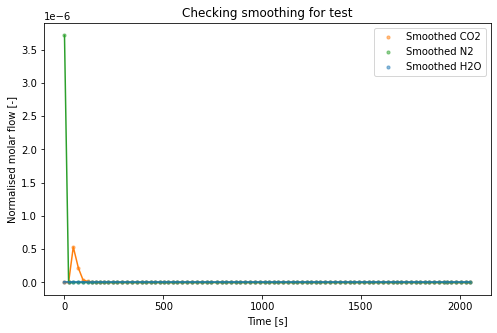

In [36]:
df_plot = pd.read_csv(filelabel + '.csv')
plt.rcParams.update({'font.size': 10})
fig, ax = plt.subplots(figsize=(8,5))
ax.scatter(df_plot['Breakthrough time [s]'], df_plot['CO2 molar flow [mol/s]'], color='tab:orange', s=10, alpha=0.5)
ax.scatter(df_plot['Breakthrough time [s]'], df_plot['N2 molar flow [mol/s]'], color='tab:green', s=10, alpha=0.5)
ax.scatter(df_plot['Breakthrough time [s]'], df_plot['H2O molar flow [mol/s]'], color='tab:blue', s=10, alpha=0.5)
ax.plot(df_plot['Breakthrough time [s]'], df_plot['CO2 molar flow [mol/s]'], color='tab:orange', linestyle='-')
ax.plot(df_plot['Breakthrough time [s]'], df_plot['N2 molar flow [mol/s]'], color='tab:green', linestyle='-')
ax.plot(df_plot['Breakthrough time [s]'], df_plot['H2O molar flow [mol/s]'], color='tab:blue', linestyle='-')
ax.legend(['Smoothed CO2', 'Smoothed N2', 'Smoothed H2O'])
ax.set(xlabel='Time [s]', ylabel=('Normalised molar flow [-]'))
ax.set_title('Checking smoothing for ' + filelabel)
plt.show()